In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

In [3]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [4]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DDimsNS"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDimsNS/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [5]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
print(mses)

              bw          mse
0       0.000282  3212.688229
1       0.000372  3212.650065
2       0.000491  3212.583060
3       0.000649  3212.491679
4       0.000857  3212.387010
5       0.001131  3212.114180
6       0.001493  3211.620252
7       0.001972  3210.903421
8       0.002603  3209.729429
9       0.003437  3207.661557
10      0.004538  3203.852417
11      0.005992  3196.929046
12      0.007912  3184.787068
13      0.010446  3164.082335
14      0.013793  3129.038799
15      0.018211  3067.351689
16      0.024046  2959.404429
17      0.031749  2777.345149
18      0.041919  2469.611515
19      0.055348  1971.502263
20      0.073079  1265.777041
21      0.096490   555.892805
22      0.127401   171.489684
23      0.168214    60.163124
24      0.222102    24.981854
25      0.293252    11.028803
26      0.387196     6.396099
27      0.511235     4.278653
28      0.675010     3.066370
29      0.891251     2.406884
30      1.135011     2.083834
31      1.445440     1.885671
32      1.

Text(0.5, 1.0, 'Minimum MSE is (1.542528547629993, 56)')

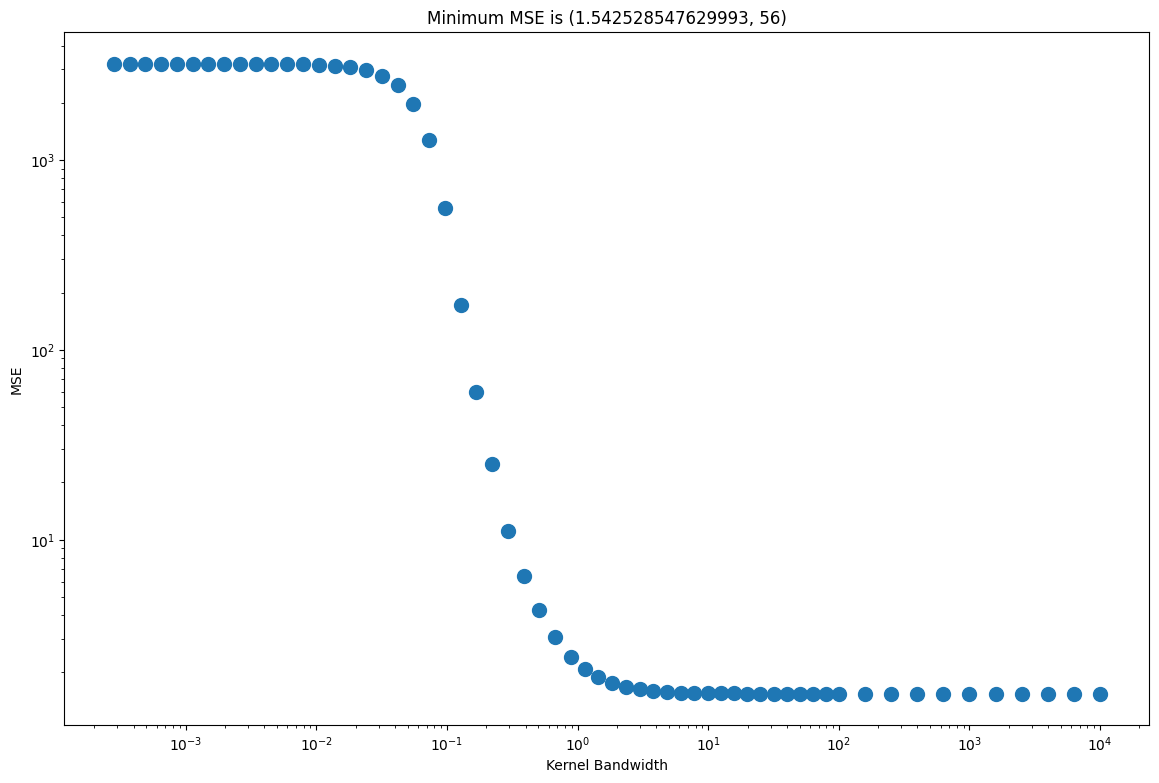

In [6]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

In [7]:
data = np.load(config.data_path, allow_pickle=True)

In [11]:
ts = data[0, :, :]
